# **Segmentación de clientes según su Personalidad**


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import pairwise_distances_argmin_min

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

In [5]:
dataframe = pd.read_csv("./personalidad.csv")
dataframe.head()

,usuario,op,co,ex,ag,ne,wordcount,categoria
0,3gerardpique,34.297953,28.148819,41.948819,29.370315,9.841575,37.0945,7
1,aguerosergiokun,44.986842,20.525865,37.938947,24.279098,10.362406,78.7970,7
2,albertochicote,41.733854,13.745417,38.999896,34.645521,8.836979,49.2604,4
3,AlejandroSanz,40.377154,15.377462,52.337538,31.082154,5.032231,80.4538,2
4,alfredocasero1,36.664677,19.642258,48.530806,31.138871,7.305968,47.0645,4


las variables son 


*  “op” = Openness to experience – grado de apertura mental a nuevas experiencias, curiosidad, arte
* “co” =Conscientiousness – grado de orden, prolijidad, organización
* “ex” = Extraversion – grado de timidez, solitario o participación ante el grupo social
* “ag” = Agreeableness – grado de empatía con los demás, temperamento
* “ne” = Neuroticism, – grado de neuroticismo, nervioso, irritabilidad, seguridad en sí mismo.
* Wordcount – Cantidad promedio de palabras usadas en sus tweets
* Categoria – Actividad laboral del usuario (actor, cantante, etc.)ta



El archivo contiene diferenciadas 9 categorías -actividades laborales- que son:
1. Actor/actriz
2. Cantante
3. Modelo
4. Tv, series
5. Radio
7. Tecnología
8. Deportes
9. Politica
10. Escrito



## **Analisis exploratorio de la data**

numero de registros por categoria


In [6]:
dataframe.groupby("categoria").size()

categoria
1    27
2    34
3     9
4    19
5     4
6     8
7    17
8    16
9     6
dtype: int64

Graficamos la distribucion de la data

<AxesSubplot:xlabel='wordcount', ylabel='Count'>

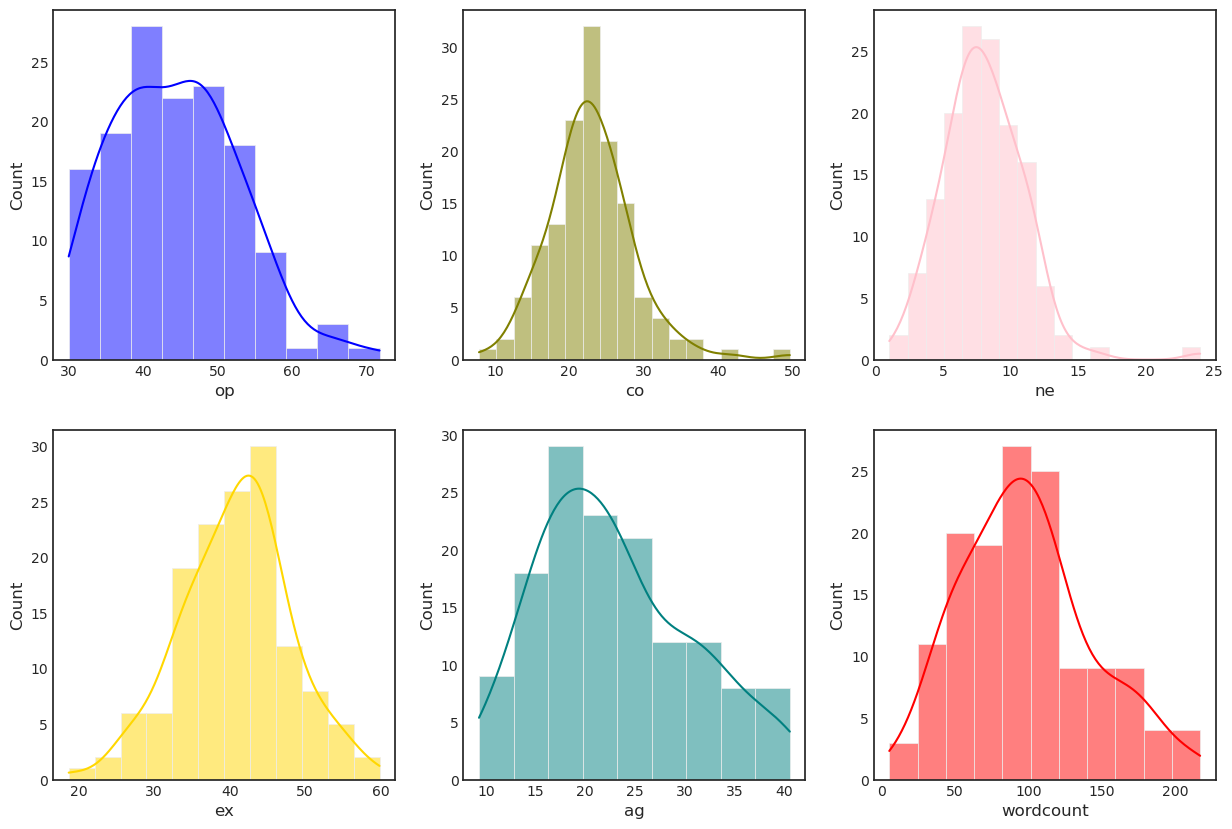

In [9]:
plt.style.use('seaborn-white')
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
sns.histplot(data = dataframe, x = "op", kde= True, color="blue", ax=axs[0, 0])
sns.histplot(data = dataframe, x = "co", kde= True, color="olive", ax=axs[0, 1])
sns.histplot(data = dataframe, x = "ex", kde= True, color="gold", ax=axs[1, 0])
sns.histplot(data = dataframe, x = "ag", kde= True, color="teal", ax=axs[1, 1])
sns.histplot(data = dataframe, x = "ne", kde= True, color="pink", ax=axs[0, 2])
sns.histplot(data = dataframe, x = "wordcount", kde=True, color="red", ax=axs[1, 2])

En este caso seleccionamos 3 dimensiones: op, ex y ag y las cruzamos para ver si nos dan alguna pista de su agrupación y la relación con sus categorías.

### Escalamos la Data

Definimos la entrada
Concretamos la estructura de datos que utilizaremos para alimentar el algoritmo. Como se ve, sólo cargamos las columnas op, ex y ag en nuestra variable X.

In [10]:
df = dataframe.set_index("usuario")
X = df.drop("categoria", axis =1)
y = df["categoria"]
print(X.shape)
print(y.shape)

(140, 6)
(140,)


In [11]:
X.head(5)

,op,co,ex,ag,ne,wordcount
usuario,,,,,,
3gerardpique,34.297953,28.148819,41.948819,29.370315,9.841575,37.0945
aguerosergiokun,44.986842,20.525865,37.938947,24.279098,10.362406,78.7970
albertochicote,41.733854,13.745417,38.999896,34.645521,8.836979,49.2604
AlejandroSanz,40.377154,15.377462,52.337538,31.082154,5.032231,80.4538
alfredocasero1,36.664677,19.642258,48.530806,31.138871,7.305968,47.0645


In [12]:
#Escalamos la data
from sklearn.preprocessing import scale
X_scaled = scale(X)

In [13]:
X_scaled[0:5,:]

array([[-1.20499609,  0.89227886,  0.16542841,  0.84561194,  0.6080745 ,
        -1.38306004],
       [ 0.06816102, -0.42292159, -0.39464568,  0.1783249 ,  0.78005819,
        -0.44706295],
       [-0.31930346, -1.59276314, -0.2464589 ,  1.53701373,  0.27634669,
        -1.11000094],
       [-0.48090044, -1.3111838 ,  1.61646035,  1.06997636, -0.98001978,
        -0.40987669],
       [-0.92309481, -0.57537172,  1.08475959,  1.07741005, -0.2292087 ,
        -1.1592871 ]])

In [14]:
X_scaled2 = pd.DataFrame(data=X_scaled, index = X.index, columns = X.columns )
X_scaled2.head(5)

,op,co,ex,ag,ne,wordcount
usuario,,,,,,
3gerardpique,-1.204996,0.892279,0.165428,0.845612,0.608075,-1.383060
aguerosergiokun,0.068161,-0.422922,-0.394646,0.178325,0.780058,-0.447063
albertochicote,-0.319303,-1.592763,-0.246459,1.537014,0.276347,-1.110001
AlejandroSanz,-0.480900,-1.311184,1.616460,1.069976,-0.980020,-0.409877
alfredocasero1,-0.923095,-0.575372,1.084760,1.077410,-0.229209,-1.159287


In [18]:
df_scaled =  pd.concat([X_scaled2, y], axis = 1)
df_scaled.shape

(140, 7)

/home/eros/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


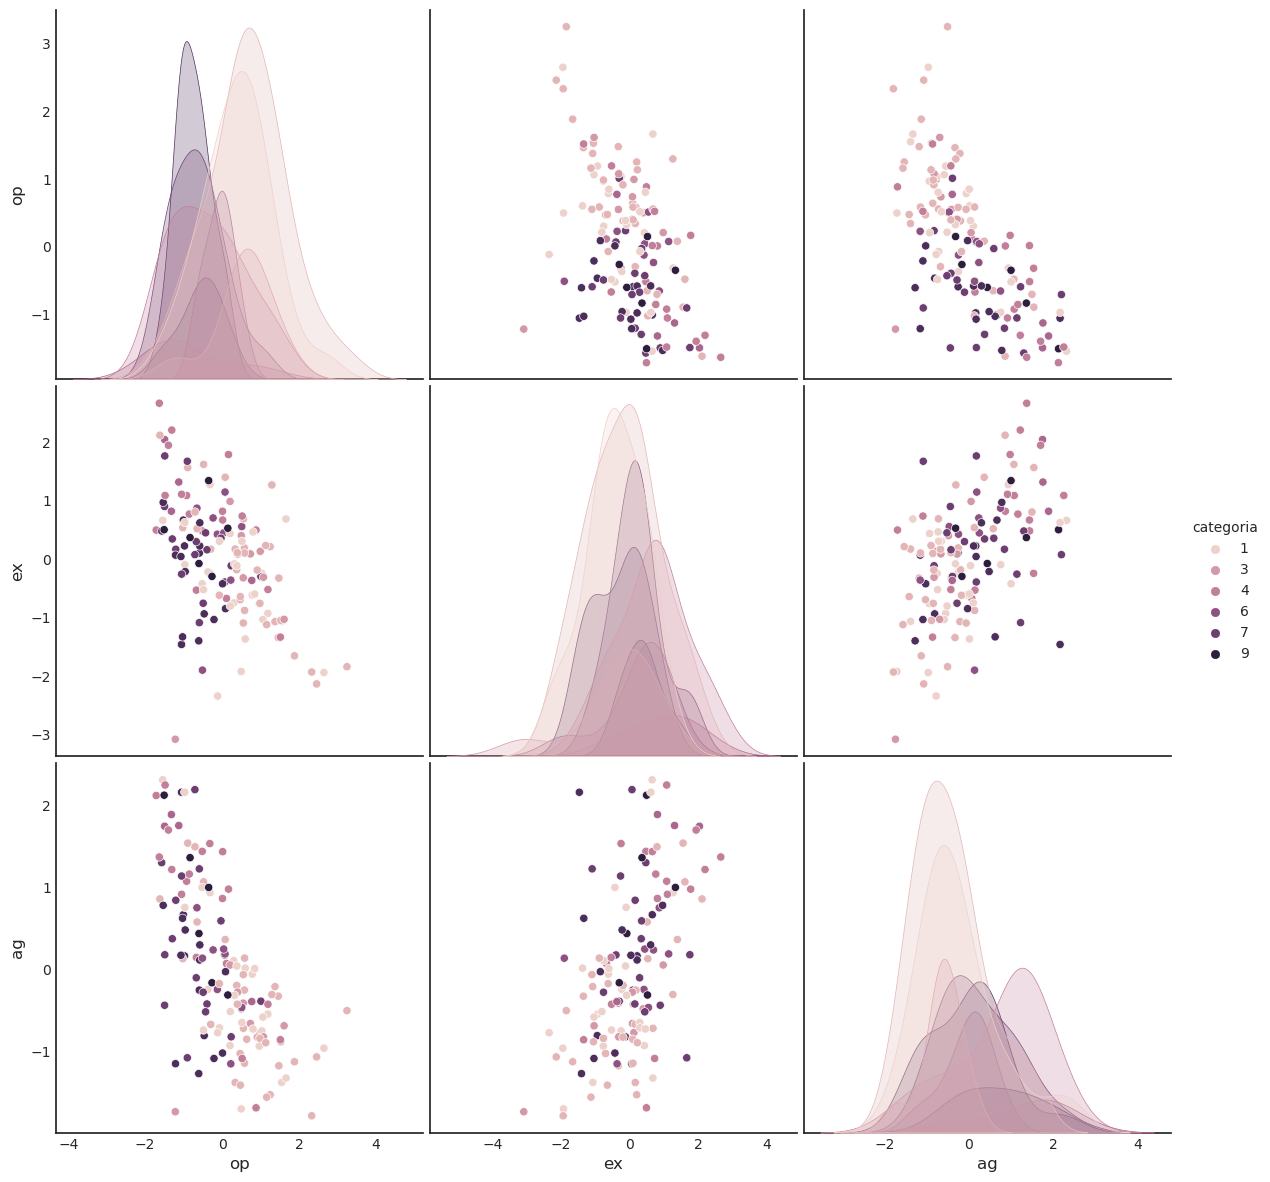

In [19]:
sns.pairplot(df_scaled.dropna(), 
            hue='categoria',
            size=4,
            vars=["op","ex","ag"],
            kind='scatter',
           # palette='viridis'
            )

## **Cluster con K-means**

### Obtener el valor optimo de K

Realizamos una segmentacion para 2, 3 y 6 cluster

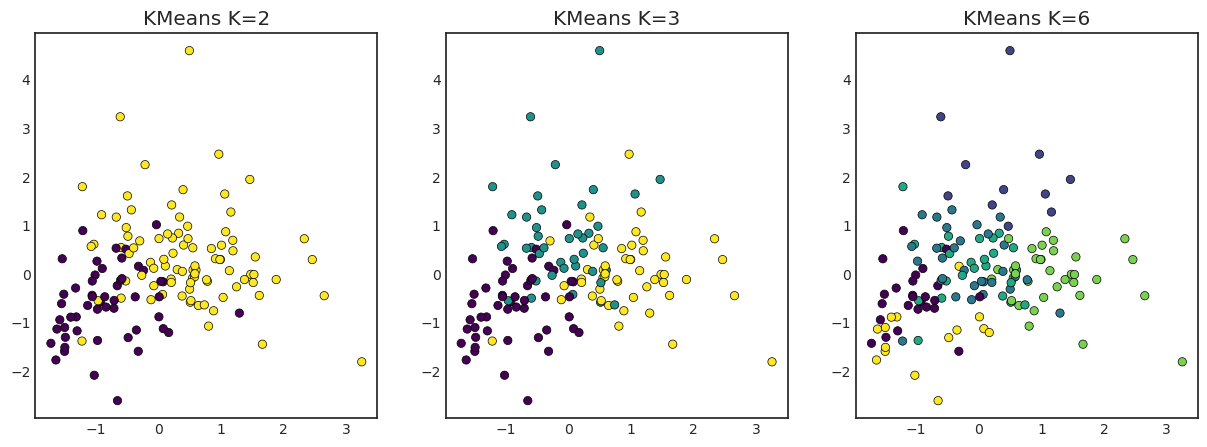

In [22]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Resultados para K = 2, 
# con 25 centroides diferentes, eligiendo la solución con menor suma de distanias
y_predict = KMeans(n_clusters=2, n_init=25, random_state=123).fit_predict(X=X_scaled2)

ax[0].scatter(x = X_scaled2["op"],
              y = X_scaled2["co"], 
              c = y_predict,
              cmap='viridis',
              marker    = 'o',
              edgecolor = 'black' )
ax[0].set_title('KMeans K=2');

# Resultados para K = 3
y_predict = KMeans(n_clusters= 3, n_init=25, random_state=123).fit_predict(X=X_scaled2)

ax[1].scatter(x = X_scaled2["op"],
              y = X_scaled2["co"], 
              c = y_predict,
              cmap='viridis',
              marker    = 'o',
              edgecolor = 'black' )
ax[1].set_title('KMeans K=3');

# Resultados para K = 6

y_predict = KMeans(n_clusters=6, n_init=25, random_state=123).fit_predict(X=X_scaled2)
ax[2].scatter(x = X_scaled2["op"],
              y = X_scaled2["co"], 
              c = y_predict,
              cmap='viridis',
              marker    = 'o',
              edgecolor = 'black' )
ax[2].set_title('KMeans K=6');

Metodo del Codo

In [23]:
from sklearn.cluster import KMeans
cs = []
Nc = range(1,11)
for i in Nc:
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(X_scaled2)
    cs.append(kmeans.inertia_) #Avg Within = -Score(X)


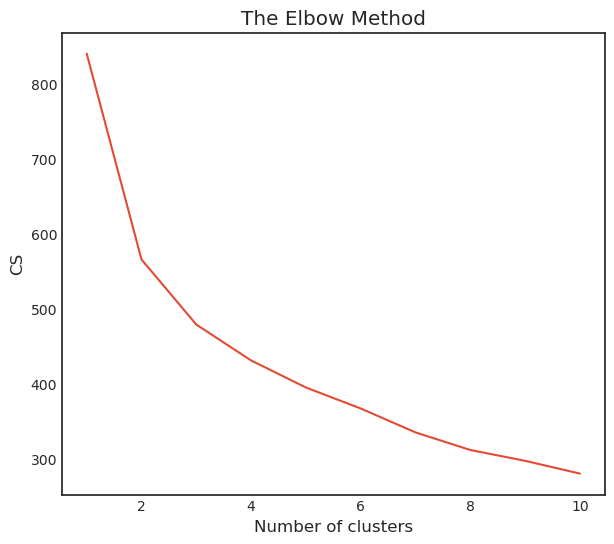

In [24]:
plt.figure(figsize = (7,6))
plt.plot(Nc, cs)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('CS')
plt.show()

### Segmentamos personas

Ejecutamos el algoritmo para 3 clusters y obtenemos las etiquetas y los centroids.

In [29]:
kmeans = KMeans(n_clusters=3).fit(X_scaled)
kmeans.labels_ #etiquetas de cluster

array([2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 0, 2, 0, 1, 1, 0, 2, 1, 0, 2, 2, 1,
       0, 2, 0, 1, 2, 1, 2, 0, 1, 0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 1,
       0, 1, 1, 0, 2, 2, 0, 2, 2, 0, 2, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 2, 2, 1, 1, 1, 1, 0, 1, 2, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0,
       1, 1, 0, 1, 1, 0, 1, 1, 2, 0, 2, 1, 0, 0, 1, 2, 0, 0, 2, 2, 1, 1,
       1, 2, 2, 2, 1, 1, 1, 0, 2, 1, 1, 2, 2, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 2, 2, 0, 0, 2], dtype=int32)

In [30]:
#Incluimos en la data original
dataframe["cluster_km"] = kmeans.labels_
dataframe.head(5)

,usuario,op,co,ex,ag,ne,wordcount,categoria,cluster_km
0,3gerardpique,34.297953,28.148819,41.948819,29.370315,9.841575,37.0945,7,2
1,aguerosergiokun,44.986842,20.525865,37.938947,24.279098,10.362406,78.7970,7,1
2,albertochicote,41.733854,13.745417,38.999896,34.645521,8.836979,49.2604,4,2
3,AlejandroSanz,40.377154,15.377462,52.337538,31.082154,5.032231,80.4538,2,2
4,alfredocasero1,36.664677,19.642258,48.530806,31.138871,7.305968,47.0645,4,2


Vemos los centroides de cada cluster

In [38]:
centroids = kmeans.cluster_centers_
print(centroids)

[[ 0.99004819  0.23672705 -0.53362179 -0.79790817 -0.62433161  0.28071699]
 [-0.12866879  0.4485327  -0.36506433 -0.30263567  0.8947604   0.56789956]
 [-0.82548859 -0.65670727  0.86124086  1.05468785 -0.25916092 -0.81325753]]


### Caracteristicas de los Clusters

In [39]:
dataframe["cluster_km"].value_counts()

2    48
1    46
0    46
Name: cluster_km, dtype: int64

* la diferencia no suele ser muy significativa, lo que se entiende que la clasificación es la adecuada

<AxesSubplot:xlabel='cluster_km', ylabel='count'>

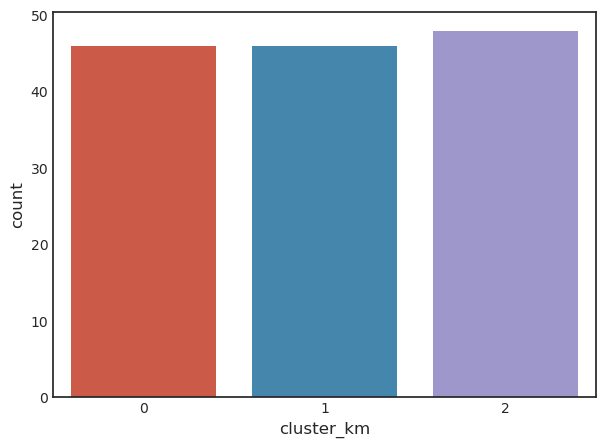

In [40]:
plt.figure(figsize = (7,5))
sns.countplot(data = dataframe, x = "cluster_km")

In [41]:
dataframe.groupby("cluster_km").mean()

,op,co,ex,ag,ne,wordcount,categoria
cluster_km,,,,,,,
0,52.726617,24.349215,36.943942,16.830707,6.109388,111.222574,2.130435
1,43.334342,25.576849,38.150736,20.609501,10.709767,124.017733,5.108696
2,37.484138,19.170834,46.930515,30.965507,7.215261,62.481533,4.875000


**Observaciones**
* Dentro de la OP vemos que el cluster 0 son los que tienen mayor apartura mental, mientras que los que están en el cluster 1 son más conservadores
* Los del cluster 2 son personas que escriben en promedio mayor cantidad de palabras en el tweet

## **Cluster Jerarquico**

In [42]:
from scipy.cluster.hierarchy import dendrogram, linkage

Enlace promedio y metrica euclidea

In [43]:
hikerical_av=  linkage(X_scaled, "average", metric = "euclidean")

* average -> metodo para calcular las distancias entre los diferentes grupos cuando se estan conbinando
* euclidean -> Metodo que se utiliza para calcular la distancia entre los puntos de datos

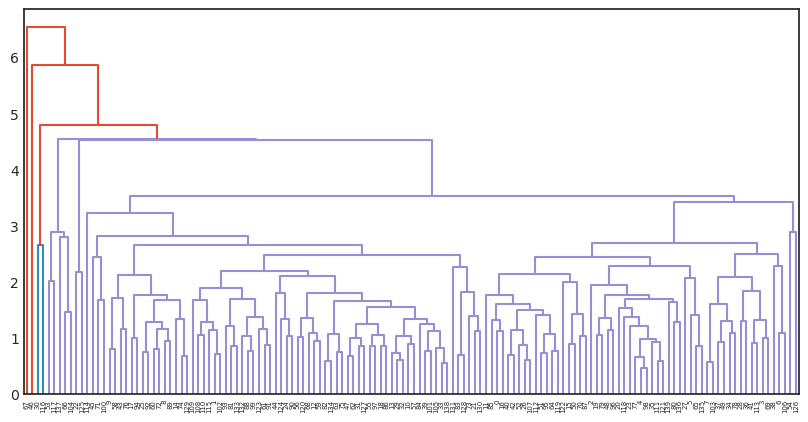

In [44]:
#grafica del dendrograma
plt.figure(figsize = (10,5))
dendrogram(hikerical_av)
plt.show()

* Se recomienda su uso cuando son pocas observaciones, agencias, regisones, sectores economicos, perfiles de clientes

Enlace completo y metrica euclidea

In [46]:
hikerical_c=  linkage(X_scaled, "complete", metric = "euclidean")

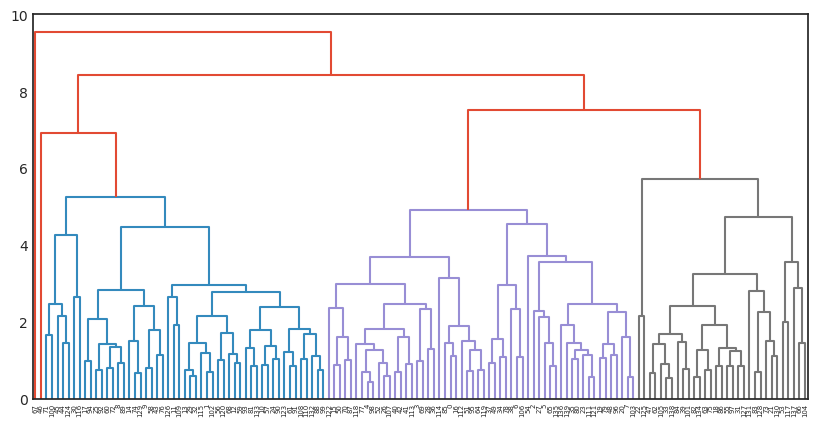

In [47]:
#grafica del dendrograma
plt.figure(figsize = (10,5))
dendrogram(hikerical_c)
plt.show()

Enlace Ward y metrica euclidea

In [48]:
hikerical_ward=  linkage(X_scaled, "ward", metric = "euclidean")

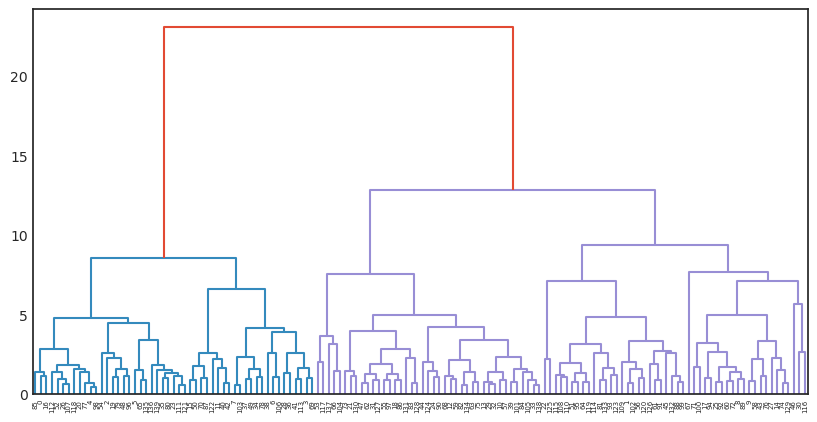

In [49]:
#grafica del dendrograma
plt.figure(figsize = (10,5))
dendrogram(hikerical_ward)
plt.show()

In [50]:
#otra forma de creae clusters
hierarchical_cluster = AgglomerativeClustering(n_clusters=3, 
                                               affinity='euclidean',  #medida de distancia
                                               linkage='ward') #medida de similitud (enlace)
labels_h = hierarchical_cluster.fit_predict(X_scaled)

In [51]:
labels_h

array([1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 2, 1, 2, 2, 0, 1, 1, 0, 2, 1, 1, 2,
       0, 1, 2, 0, 1, 0, 1, 2, 0, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 0,
       2, 0, 0, 2, 1, 1, 1, 0, 1, 2, 1, 2, 0, 2, 0, 2, 0, 0, 2, 2, 0, 1,
       2, 0, 2, 1, 1, 0, 0, 2, 0, 2, 0, 1, 1, 1, 1, 0, 2, 2, 2, 1, 2, 1,
       0, 0, 2, 0, 0, 0, 0, 0, 1, 2, 1, 0, 0, 2, 0, 1, 2, 2, 1, 1, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 2, 1, 0, 0, 1, 1, 0, 2, 0, 0, 2, 2, 0, 2, 2,
       0, 0, 2, 1, 1, 2, 2, 1])

In [52]:
dataframe["cluster_h"] = labels_h

In [53]:
dataframe.head()

,usuario,op,co,ex,ag,ne,wordcount,categoria,cluster_km,cluster_h
0,3gerardpique,34.297953,28.148819,41.948819,29.370315,9.841575,37.0945,7,2,1
1,aguerosergiokun,44.986842,20.525865,37.938947,24.279098,10.362406,78.7970,7,1,0
2,albertochicote,41.733854,13.745417,38.999896,34.645521,8.836979,49.2604,4,2,1
3,AlejandroSanz,40.377154,15.377462,52.337538,31.082154,5.032231,80.4538,2,2,1
4,alfredocasero1,36.664677,19.642258,48.530806,31.138871,7.305968,47.0645,4,2,1


**observaciones**
* se observa que para kmeans el grupo 2 es lo mismo que el grupo 1 para la jerarquica

In [ ]:
dataframe.groupby("cluster_h").mean()

,op,co,ex,ag,ne,wordcount,categoria,cluster_km
cluster_h,,,,,,,,
0,43.040667,26.618861,37.384998,20.254385,10.191033,123.213058,4.875000,1.875000
1,38.161893,19.304132,46.815814,30.362315,7.143658,63.935053,4.764706,0.039216
2,53.800834,23.282510,37.193500,16.778179,6.500428,113.298859,2.195122,1.146341


## **Interpretación de los clusters**

Ahora veremos como interpretar los cluster generados ......

In [ ]:
pd.crosstab(dataframe["cluster_km"], dataframe["cluster_h"])

cluster_h,0,1,2
cluster_km,,,
0,2,49,0
1,2,2,35
2,44,0,6


In [ ]:
#promedio de los indicadore por cluster
dataframe.groupby("cluster_km").mean()

,op,co,ex,ag,ne,wordcount,categoria,cluster_h
cluster_km,,,,,,,,
0,37.667270,19.204450,46.681210,30.679688,7.383326,64.563071,4.843137,0.960784
1,53.535646,23.190559,36.010625,16.519986,6.150306,103.482487,2.153846,1.846154
2,44.182435,26.658804,38.437276,19.993007,10.072043,129.832682,4.720000,0.240000


In [ ]:
dataframe.groupby("cluster_h").mean()

,op,co,ex,ag,ne,wordcount,categoria,cluster_km
cluster_h,,,,,,,,
0,43.040667,26.618861,37.384998,20.254385,10.191033,123.213058,4.875000,1.875000
1,38.161893,19.304132,46.815814,30.362315,7.143658,63.935053,4.764706,0.039216
2,53.800834,23.282510,37.193500,16.778179,6.500428,113.298859,2.195122,1.146341


realizamos graficas de dispersion entre las diferentes variables por grupos generados

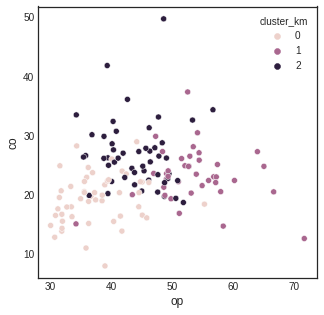

In [ ]:
# OP vs CO
plt.figure(figsize = (5,5))
sns.scatterplot(x = "op", y = "co", data = dataframe, hue = "cluster_km" )

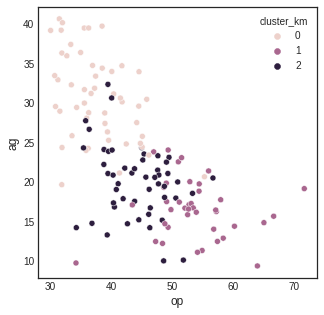

In [ ]:
# OP vs CO
plt.figure(figsize = (5,5))
sns.scatterplot(x = "op", y = "ag", data = dataframe, hue = "cluster_km" )

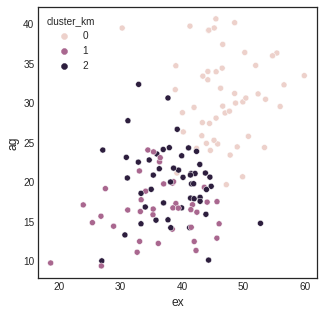

In [ ]:
# OP vs CO
plt.figure(figsize = (5,5))
sns.scatterplot(x = "ex", y = "ag", data = dataframe, hue = "cluster_km" )

Graficos Pairplot

In [ ]:
dataframe

,usuario,op,co,ex,ag,ne,wordcount,categoria,cluster_km,cluster_h
0,3gerardpique,34.297953,28.148819,41.948819,29.370315,9.841575,37.0945,7,0,1
1,aguerosergiokun,44.986842,20.525865,37.938947,24.279098,10.362406,78.7970,7,2,0
2,albertochicote,41.733854,13.745417,38.999896,34.645521,8.836979,49.2604,4,0,1
3,AlejandroSanz,40.377154,15.377462,52.337538,31.082154,5.032231,80.4538,2,0,1
4,alfredocasero1,36.664677,19.642258,48.530806,31.138871,7.305968,47.0645,4,0,1
...,...,...,...,...,...,...,...,...,...,...
135,XabiAlonso,35.569389,22.133740,38.904885,31.624351,12.201221,47.5420,7,0,1
136,XaviRodriguez,31.960417,15.416979,48.533125,40.096458,11.764583,47.5625,4,0,1
137,xoellopez,71.696129,12.489274,27.571210,19.093548,3.241935,74.3065,2,1,2
138,ZacEfron,51.537405,26.009695,36.465344,23.008168,7.284962,118.6107,1,1,2


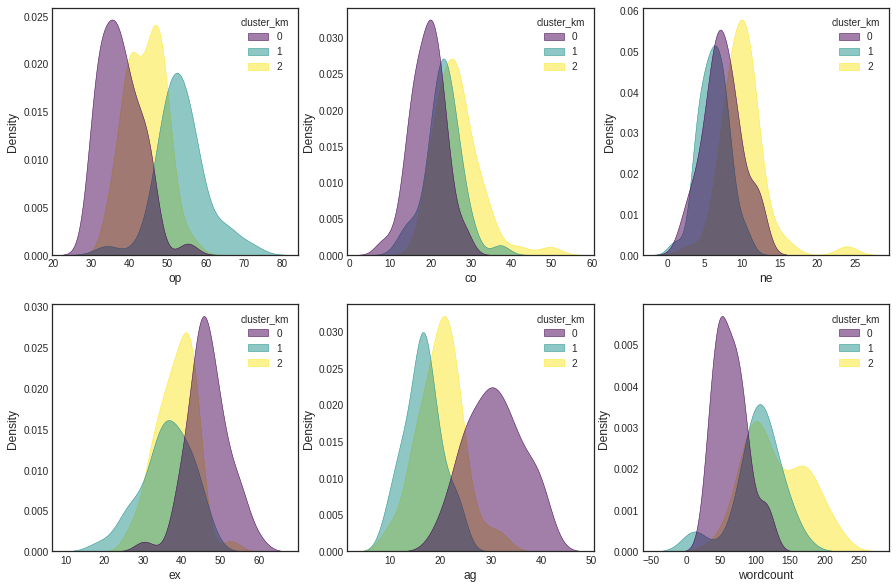

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
plt.style.use('seaborn-whitegrid')
sns.kdeplot(data = dataframe, x = "op",  hue = "cluster_km", fill=True, palette="viridis", legend= True,alpha=0.5,  ax=axs[0, 0])
sns.kdeplot(data = dataframe, x = "co",  hue = "cluster_km", fill=True, palette="viridis", legend= True,alpha=0.5, ax=axs[0, 1])
sns.kdeplot(data = dataframe, x = "ex", hue = "cluster_km", fill=True, palette="viridis", legend= True,alpha=0.5, ax=axs[1, 0])
sns.kdeplot(data = dataframe, x = "ag",  hue = "cluster_km", fill=True, palette="viridis", legend= True,alpha=0.5, ax=axs[1, 1])
sns.kdeplot(data = dataframe, x = "ne",  hue = "cluster_km", fill=True, palette="viridis", legend= True,alpha=0.5, ax=axs[0, 2])
sns.kdeplot(data = dataframe, x = "wordcount", hue = "cluster_km", fill=True, palette="viridis", legend= True,alpha=0.5,  ax=axs[1, 2])

Histogramas de clusters

/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


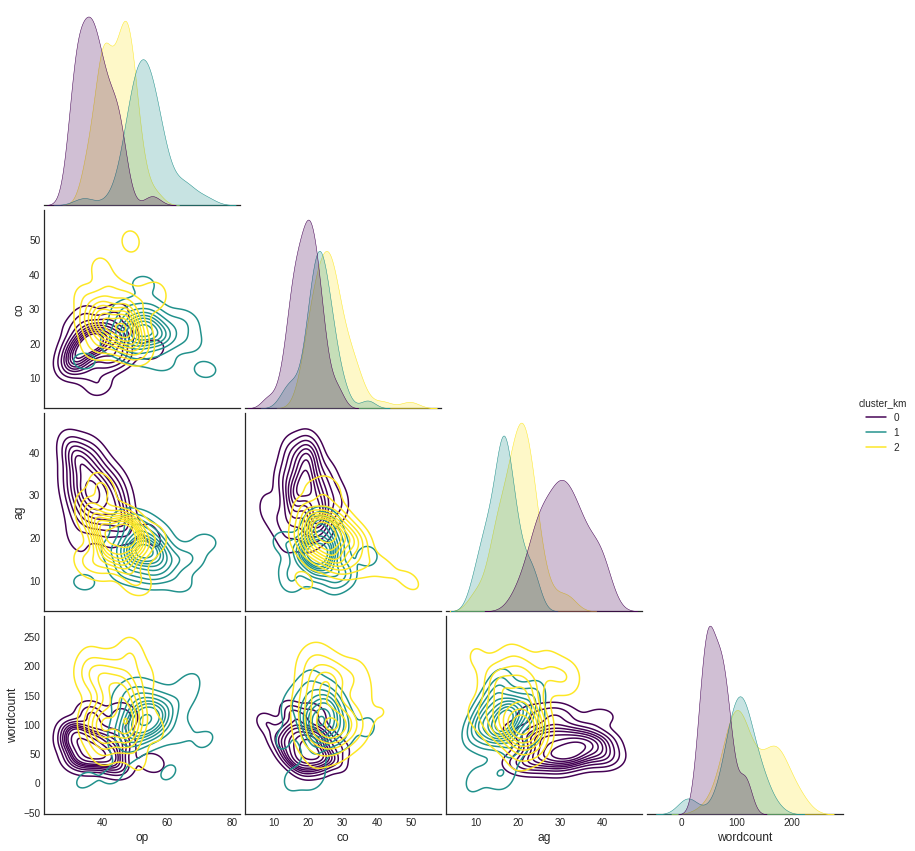

In [ ]:
plt.style.use('seaborn-white')
sns.pairplot(dataframe.drop(["categoria"], axis =1), 
            hue='cluster_km',
            size=3,
            vars=["op","co","ag", "wordcount"],
            #kind='scatter',
            palette='viridis',
            corner=True,
            kind="kde"
            )

#### Categoría vs Cluster


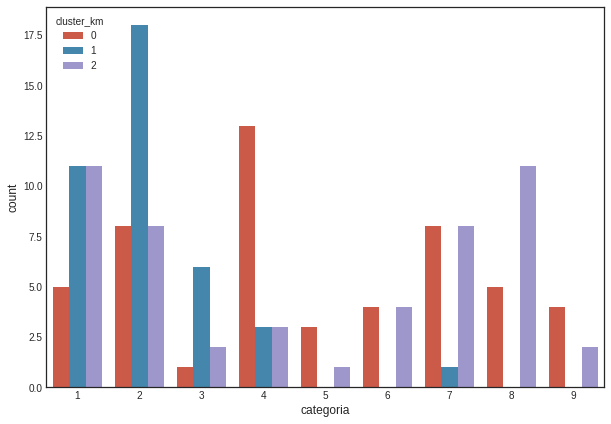

In [ ]:
plt.figure(figsize = (10,7))
sns.countplot(x = "categoria", data = dataframe, hue = "cluster_km" )

## **Gracias ....**


Puedes seguirme en mis redes Sociales para estar en contacto :)
 * [YouTube](https://www.youtube.com/c/TeExplicolaEconomia)
 * [TikTok](https://www.tiktok.com/@ecomanzanitas)
 * [Facebook](https://www.facebook.com/EconomiaConManzanitas) 
 * [Instagram](https://www.instagram.com/economia_con_manzanitas)
 * [Twitter](https://twitter.com/EconManzanitas)
